# Predicting Heart Disease With Age, Serum Cholesterol, Resting Blood Pressure and Maximum Heart Rate Using KNN Classification Method


## Introduction
Heart disease refers to several types of heart conditions, which is the main cause of death in the USA for most racial and ethnic groups (1). The main heart disease risk factors are high blood pressure, high blood cholesterol, smoking, and age(2). Some of the common heart disease symptoms are chest pain, irregular heartbeats (heartbeats too fast or too slow or irregularly), Pain in the back, and shortness of breath (2). A doctor usually diagnoses patients as either healthy or having a heart disease based on their risk factors and symptoms. As a result, a doctor may predict heart disease based on the current situation and past experiments. The Heart disease data was downloaded from Kaggle to use for predicting heart disease (3). We will use the “Heart Failure Prediction Dataset” to answer this question. This dataset contains 11 variables; however, Age, RestingBP, Cholesterol, and MaxHR variables will be used to predict the heart disease status (1 = heart disease and 0 = normal).



#### Question: 
   Can we use the age, normal blood pressure when the body is at rest, maximum heart rate achieved, and blood cholesterol level variables to predict if the patient has heart disease? 


   



# Methods and Results

In [26]:
### Loading Libraries into R
library(tidyverse)
library(tidymodels)
library(cowplot)

library(repr)
options(repr.matrix.max.rows = 6)

#set the seed
set.seed(123) 

### Loading the Data
The Heart disease data was downloaded from Kaggle as a CSV file and was saved to the 'data' folder.

???? fix it, should not be from kaggle

In [27]:
describe each country

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected symbol
1: describe each
             ^


In [28]:
#Reading data from the "data" folder, no data explaination on the csv file, no need for skipping. 
#data is tidy 
#we read the data into R as "data"
url1<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data"
url2<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
url3<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"

data1 <- read_csv(url1, col_names=FALSE)
data2 <- read_csv(url2, col_names=FALSE)
data3 <- read_csv(url3, col_names=FALSE)

heart_data <- rbind(data1, data2, data3)
print(heart_data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

# A tibble: 720 × 14
      X1    X2    X3 X4    X5    X6    X7    X8    X9    X10   X11   X12   X13  
   <dbl> <dbl> <dbl> <chr> <chr> <chr> <chr> <chr> <chr> <chr> <chr> <chr> <chr>
 1    28     1     2 130   132   0     2     185   0     0     ?     ?     ?    
 2    29     1     2 120   243   0     0     160   0     0     ?     ?     ?    
 3    29     1     2 140   ?     0     0     170   0     0     ?     ?     ?    
 4    30     0     1 170   237   0     1     170   0     0     ?     ?     6    
 5    31     0     2 100   219   0     1     150   0     0     ?     ?     ?    
 6    32     0     2 105   198   0     0     165   0     0     ?     ?     ?    
 7    32     1     2 110   225   0     0     184   0     0     ?     ?     ?    
 8    32     1     2 125   254   0     0     155   0     0     ?     ?     ?    
 9    33     1     3 120   298   0     0     185   0     0     ?     ?     ?    
10    34     0     2 130   161   0     0     190   0     0     ?     ?     ?    
# … wit

In [29]:
change col names 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:8: unexpected symbol
1: change col
           ^


### Variable Explanation 

Age: age of the patient [years]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

HeartDisease:[1: heart disease, 0: Normal]

### Wrangling & Cleaning the Data
The data is tibble, and the `Cholesterol` = 0 is equivalent to NA in this data set. Except`Cholesterol`, all the other variables do not contain NA. Therefore, we are selecting the following numerical variables as our predictors for the model:  
age, resting blood pressure (mmHg), maximum heart rate, and serum cholesterol level (mm/dl).

In [30]:
print("Table 1. Number of missing data for cholestrol variable")
heart_data|>
        filter(Cholesterol==0)|>
        group_by(Cholesterol)|>
        summarize(n=n())


[1] "Table 1. Number of missing data for cholestrol variable"


ERROR: [1m[33mError[39m in [1m[1m`filter()`:[22m
[1m[22m[33m![39m Problem while computing `..1 = Cholesterol == 0`.
[1mCaused by error in [1m[1m`mask$eval_all_filter()`:[22m
[33m![39m object 'Cholesterol' not found


Table 1 suggests that blood cholestrol data of 172 patients is missing, so the data set is filtered to remove `Cholesterol` = 0. Therefore, in the data set, filter() function was used to eliminate those variables that do not contain observation.

In [4]:
#We filter against NA in Cholesterol
heartdisease_data <- heart_data|> 
    filter(Cholesterol!=0)

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
40,M,ATA,140,289,0,Normal,172,N,0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1,Flat,1
37,M,ATA,130,283,0,ST,98,N,0,Up,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In the above data set `HeartDisease` was incorrectly stored as a numerical (dbl) column; therefore, we use mutate() function to turn it into a factor. 
Then the following variables that contain observation (`Age`, `RestingBP`, `Cholesterol` and `MaxHR`)
are selected as these are predictors in this model. 

In [5]:
#Convert the character class variable to the factor data type
data_heart <- heartdisease_data|>
        mutate(HeartDisease = as.factor(HeartDisease))|>
        select(Age, RestingBP, Cholesterol, MaxHR, HeartDisease)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,0
49,160,180,156,1
37,130,283,98,0
⋮,⋮,⋮,⋮,⋮
57,130,131,115,1
57,130,236,174,1
38,138,175,173,0


### Splitting the Data
Splitting the data into a training set and testing set using 75% of the data for training. We are splitting the data into training and testing sets in order to evaluate our model prediction accuracy.

In [20]:
set.seed(123)
heart_split <- initial_split(data_heart, prop = 0.75, strata = HeartDisease) 
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

Finding the ratio of each class of the target variable (0 = Normal, 1 = Diseased) in the training data.

In [7]:
n_row_train <- nrow(heart_train)
data_train_percentage <- heart_train |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row_train*100)
print("Table 2. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the training data")
data_train_percentage

[1] "Table 2. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the training data"


HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,292,52.23614
1,267,47.76386


Table 2 suggests the distribution of the target variable classes 0 (normal, 52%) and 1 (diseased, 48%) are very close. In other words, half of the observations are normal, and the other half are diseased. This even distribution of target variable classes suggests that the dataset is not significantly influenced by one of the classes and helps us to ensure that the model does not show false accuracy.

### Explatory Data Analysis 

Table summary of the predictors and their numerical distribution (mean and variance) in each class of the target variable (0 = Normal,     1 = Diseased)

In [8]:
nheart <- heart_train |>
        group_by(HeartDisease)|>
        summarize(Observation=n())

table_3 <- heart_train|>
    group_by(HeartDisease)|>
    summarize(across(Age:MaxHR, mean, na.rm=TRUE)) 
mean_heart_disease <- merge(table_3,nheart) |>
    rename(Avg_Age = Age, Avg_RestingBP = RestingBP, Avg_Cholesterol = Cholesterol, Avg_MaxHR = MaxHR)
print("Table 3. Averages of the predictor variables in the training set")
mean_heart_disease

[1] "Table 3. Averages of the predictor variables in the training set"


HeartDisease,Avg_Age,Avg_RestingBP,Avg_Cholesterol,Avg_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,50.48288,130.1918,243.7740,149.2671,292
1,55.95506,136.3296,250.6742,129.3184,267


In [9]:
table_4 <- heart_train|>
        group_by(HeartDisease)|>
        summarize(across(Age:MaxHR, var, na.rm=TRUE)) 
variance_heart_disease <- merge(table_4,nheart) |>
    rename(var_Age = Age, var_RestingBP = RestingBP, var_Cholesterol = Cholesterol, var_MaxHR = MaxHR) 
print("Table 4. Variance of the predictor variables in the training set ")
variance_heart_disease

[1] "Table 4. Variance of the predictor variables in the training set "


HeartDisease,var_Age,var_RestingBP,var_Cholesterol,var_MaxHR,Observation
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,93.07531,252.2174,3421.076,528.6500,292
1,77.31376,337.2895,3904.702,466.9547,267


Based on the tables 3 & 4, the Mean and variance of the variables that we
want to use as predictors are not in a similar range.
Therefore, we need standardize our data by scaling 
and centring the variables to have comparable predictors.

Standardized predictors will be performed to create comparable predictors with similar mean and variance.

In [ ]:
grammer

In [10]:
set.seed(123)
data_train_recipe <- recipe(HeartDisease ~ ., data= heart_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    prep()

scaled_heart <- bake(data_train_recipe, heart_train)

Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.6702218,-0.1798122,0.5941202,-1.70717,0
-1.4626970,-0.7554996,1.5201017,1.23772,0
-0.8401227,-0.1798122,-0.1665075,1.23772,0
⋮,⋮,⋮,⋮,⋮
-0.8401227,-1.3311869,0.2799479,-0.31652748,1
1.5464123,0.6261501,-0.8940644,0.05158388,1
0.4050260,-0.1798122,-1.9192582,-1.01184894,1


### Visualization 

Visualizing the data in order to find any potential correlation between predictors and their effect on the classification of the target variables. 

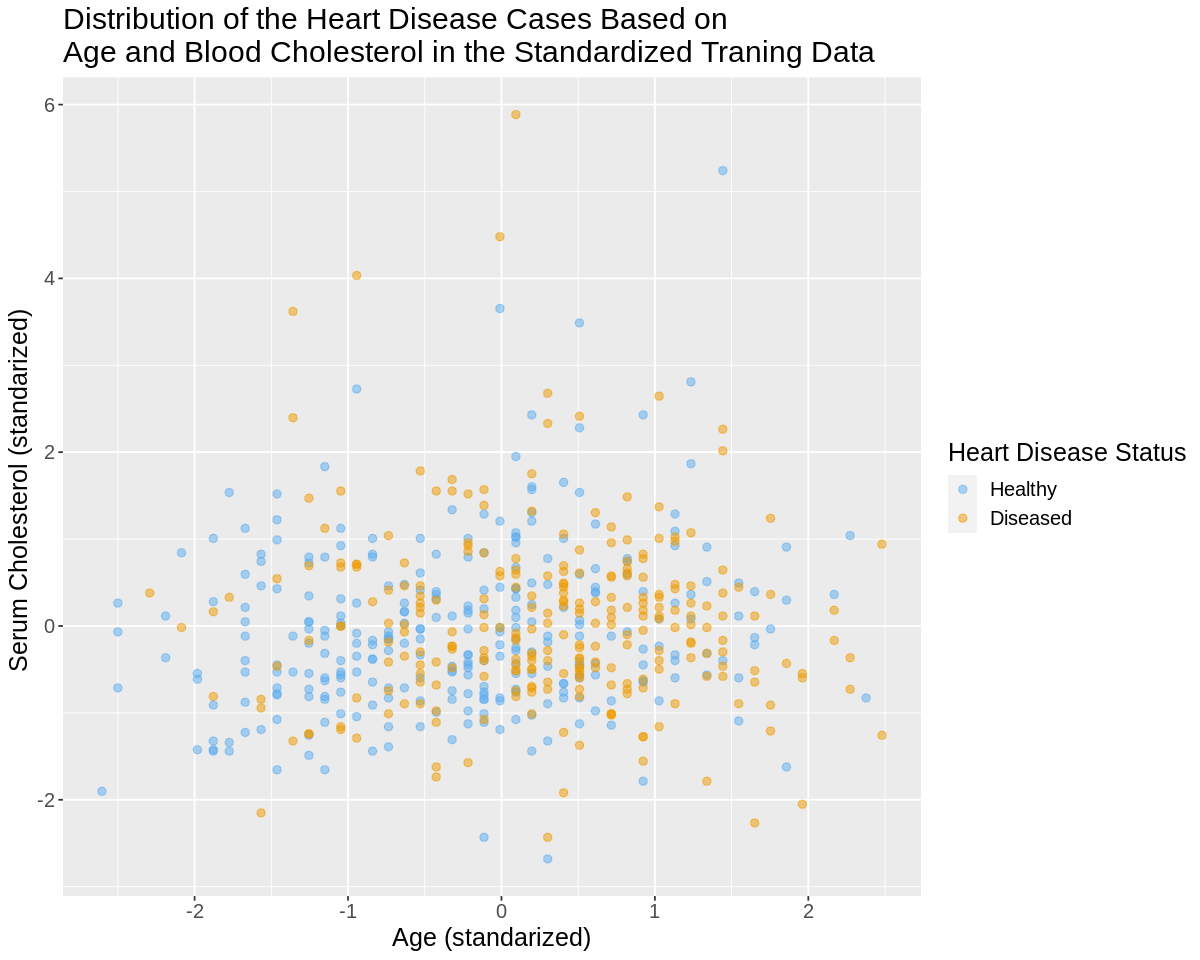

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8) 

#scaterplot resting blood pressure and age 
agevsbp <- ggplot(scaled_heart, aes(x = Age, y = Cholesterol, color = HeartDisease)) +
      geom_point( alpha = 0.5, size = 2) +
      xlab("Age (standarized)") +
      ylab("Serum Cholesterol (standarized) ") +
        labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 15),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Distribution of the Heart Disease Cases Based on \nAge and Blood Cholesterol in the Standardized Traning Data") 
 agevsbp     

Figure 1: Scatter plot of Serum Cholesterol versus Age colored by heart disease status label

Figure 1 suggests that there is no correlation between age and serum cholesterol. However, the figure shows that most heart-diseased patients are at the higher end of the age axis. Surprisingly, the distribution of the ‘healthy’ and ‘diseased’ observations does not seem to be dependent on the serum cholesterol level since no pattern is seen as the cholesterol level increases. 

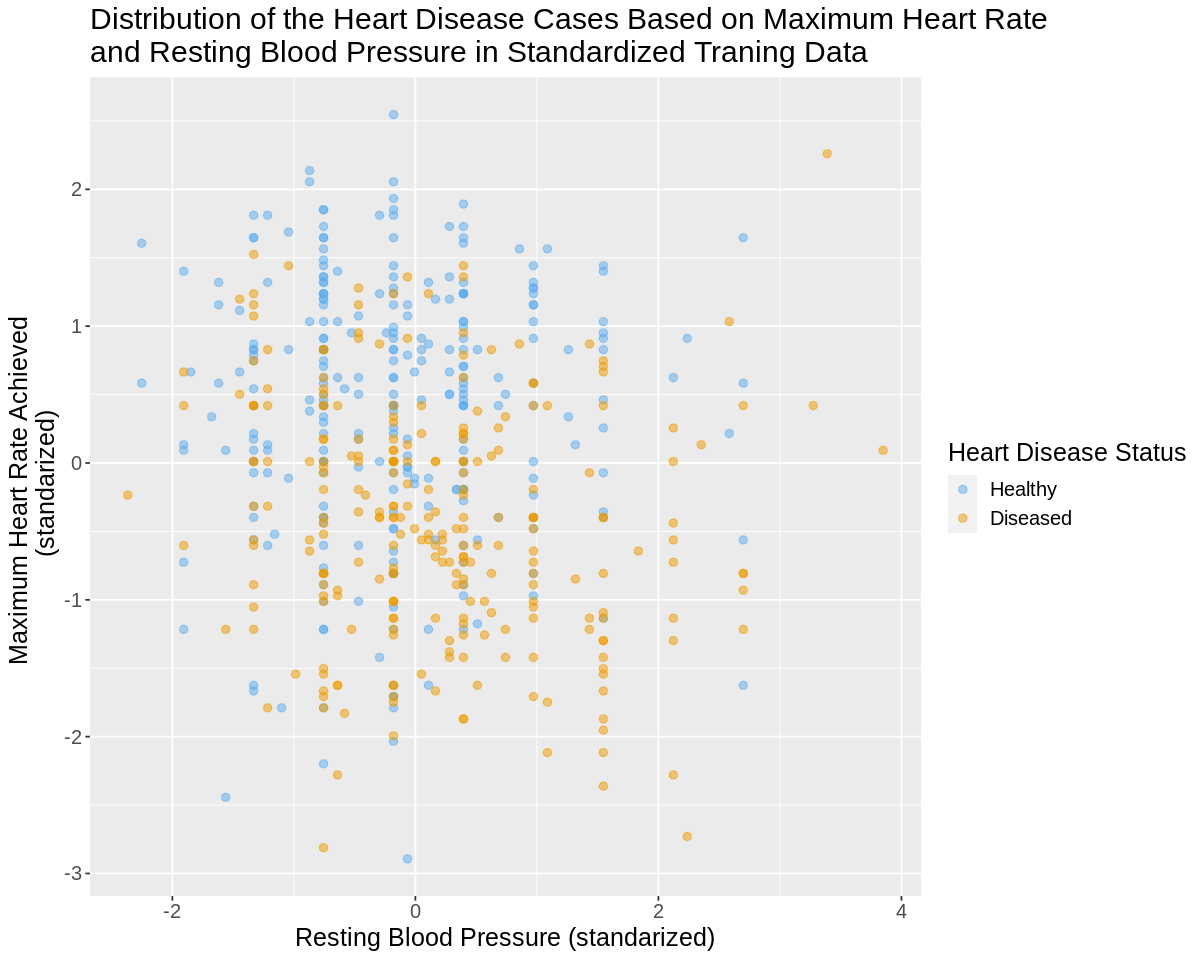

In [12]:
options(repr.plot.width = 10, repr.plot.height = 8) 
cholvshr <- ggplot(scaled_heart, aes(x = RestingBP, y = MaxHR, color = HeartDisease)) +
      geom_point(alpha = 0.5, size = 2) +
      xlab("Resting Blood Pressure (standarized)") +
      ylab("Maximum Heart Rate Achieved \n (standarized)") +
      labs(color= "Heart Disease Status")+
      theme(text = element_text(size = 15),
        legend.position = "right",
        legend.direction = "vertical") +
        scale_color_manual(labels = c("Healthy","Diseased"),
                           values= c("steelblue2","orange2"))+
        ggtitle("Distribution of the Heart Disease Cases Based on Maximum Heart Rate \nand Resting Blood Pressure in Standardized Traning Data")
cholvshr

Figure 2: Scatter plot of maximum heart rate achieved versus resting blood pressure  colored by heart disease status label

In the figure 2, resting blood pressure does not correlate with the maximum heart rate achieved. However, the figure suggests that as the maximum heart rate achieved increases, the observation of ‘healthy’ also increases. In contrast, the distribution of the healthy and heart-diseased patients seems to be not correlated with resting blood pressure.

### Determining the best k value (number of neighbors)

In [13]:
explain this
use cross valid with 10
k=5 look at long range to have more option 
k=1 take time to process

ERROR: Error in parse(text = x, srcfile = src): <text>:1:9: unexpected symbol
1: explain this
            ^


In [14]:
set.seed(123)
print ("Table 5. The nubmer of neighbors (K-value) wiht the highest accuracy")
data_vfold <- vfold_cv(heart_train, v = 10, strata = HeartDisease)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

k_vals <- tibble(neighbors= seq(from= 1, to= 100, by= 5))

knn_result <- workflow()|>
    add_recipe(data_train_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=data_vfold, grid=k_vals)|>
    collect_metrics()

accuracies <- knn_result |>
  filter(.metric == "accuracy")

maxmax<- accuracies|>
    filter(mean == max(mean))
maxmax

[1] "Table 5. The nubmer of neighbors (K-value) wiht the highest accuracy"


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
66,accuracy,binary,0.7066137,10,0.02241075,Preprocessor1_Model14


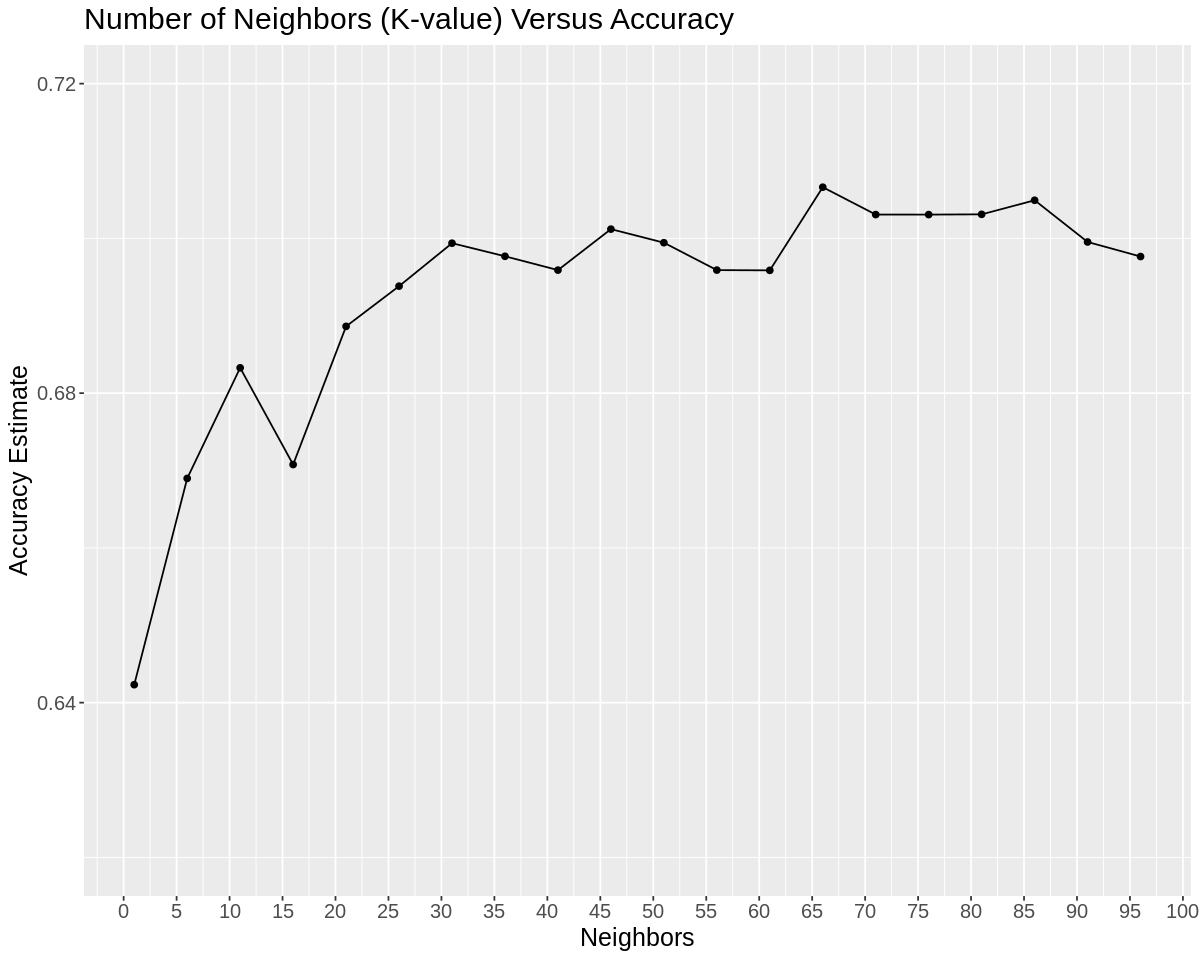

In [15]:
accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 15))+
    scale_x_continuous(breaks = seq(0, 100, by = 5))+  
    scale_y_continuous(limits = c(0.62, 0.72), breaks=seq(0.6, 1, by=0.04))+
    ggtitle ("Number of Neighbors (K-value) Versus Accuracy")
accuracy_vs_k

Figure 3: Plot of estimated accuracy versus the number of neighbors (K-value)

Based on the information in Table 5 and Figure 3, setting the number of neighbours to K = 66 gives the highest accuracy (70.66%). Figure 3 shows values after k = 30 have similar accuracy. Therefore, any selection from k= 20 to k= 95 can be reasonable, but k = 66 provides the highest accuracy, and Table 5 also approves this result.

### Finding the Accuracy of the Model Using K=66

In [ ]:
using k=66 we make a model 

In [21]:
set.seed(123)

mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 66) |>
       set_engine("kknn") |>
       set_mode("classification")

mnist_fit <- workflow() |>
            add_recipe(data_train_recipe) |>
            add_model(mnist_spec) |>
            fit(data = heart_train)

mnist_predictions <- predict(mnist_fit, heart_test)|>
        bind_cols(heart_test)

mnist_metrics <- mnist_predictions |>
        metrics(truth=HeartDisease, estimate = .pred_class) |>
        filter(.metric=="accuracy")|>
        select(.metric, .estimate)
print("Table 6. The model accuracy estimate for testing data")
mnist_metrics

[1] "Table 6. The model accuracy estimate "


.metric,.estimate
<chr>,<dbl>
accuracy,0.631016


In [67]:
set.seed (123)
n_row <- nrow(data_heart)

data_percentage <- data_heart |>
    group_by(HeartDisease)|>
    summarize(count=n(), percentage=n()/n_row*100)
print("Table 7. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the data set")
data_percentage

[1] "Table 7. Ratio and number of each class of the target variable (0 = Normal, 1 = Diseased) in the data set"


HeartDisease,count,percentage
<fct>,<int>,<dbl>
0,390,52.27882
1,356,47.72118


In [48]:
check the title

ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected symbol
1: check this
          ^


Comparing tables 6 and 7, we can see that model prediction accuracy (63.10%) is greater than the majority proportion (52.27%). This could suggest that our model has some strength in predicting the target variable. However, for the prediction of heart disease, the accuracy of 63.10% could be a better value. Heart disease is a severe disease that causes a lot of death yearly, so the accuracy for the prediction of this data should be higher to be applied. Therefore, this result suggests that prediction with the used predictor variables is insufficient; however, it is also important to check the confusion matrix. 

### Creating the confusion matrix for the model

In [68]:
mnist_conf_mat <- mnist_predictions |>
        conf_mat(truth = HeartDisease, estimate = .pred_class)
print("Table 8. Confusion matrix of heart disease prediction")
mnist_conf_mat

[1] "Table 8. Confusion matrix of heart disease prediction"


          Truth
Prediction  0  1
         0 68 39
         1 30 50

The confusion matrix (table 8) displays 68 observations were correctly predicted as healthy, and 50 were correctly predicted as diseased. However, it shows 39 patients as healthy while they were diseased, and 30 patients were predicted as diseased while they were healthy. Therefore, the classifier predicts 118 (68 + 50) observations correctly, and it determines 69 (30 + 39) observations incorrectly. As a result, this confusion matrix suggests that this prediction is not helpful as a large number of patients (39) with heart disease were misdiagnosed as healthy, and they may not receive further tests and treatments, which is dangerous.

Colored Prediction Map Visualizations 

In [37]:
final question could be how accurate could we predit only with ata chest pain

ERROR: Error in parse(text = x, srcfile = src): <text>:1:7: unexpected symbol
1: final question
          ^


Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


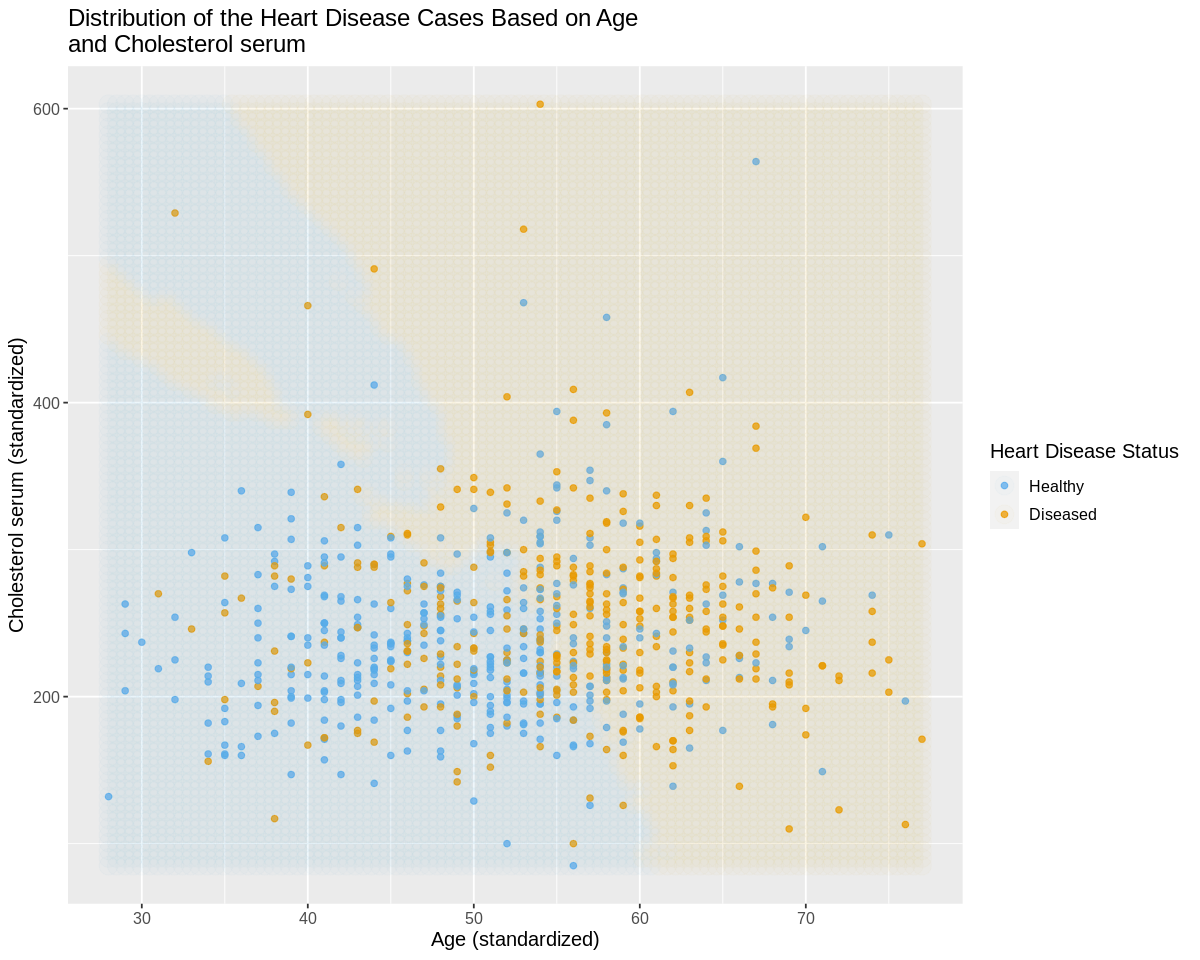

In [38]:
set.seed (123)
heart_data_2 <- read_csv("data/heart.csv") |>
    filter(Cholesterol!=0) |>
    mutate(HeartDisease = as.factor(HeartDisease))|>
    select(Age, Cholesterol, HeartDisease) 


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 66) |>
        set_engine("kknn") |>
        set_mode("classification")

uc_recipe <- recipe(HeartDisease ~ Age + Cholesterol, data = heart_data_2) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(uc_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_data_2)



set.seed(123)
age_grid <- seq(min(heart_data_2$Age), 
                max(heart_data_2$Age), 
                length.out = 100)

chol_grid <- seq(min(heart_data_2$Cholesterol), 
                max(heart_data_2$Cholesterol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(Age = age_grid, 
                                Cholesterol = chol_grid))


knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(HeartDisease = .pred_class)


wkflw_plot <-
  ggplot() +
  geom_point(data = heart_data_2, 
             mapping = aes(x = Age, 
                           y = Cholesterol, 
                           color = HeartDisease), 
             alpha = 0.75) +

  geom_point(data = prediction_table, 
             mapping = aes(x = Age, 
                           y = Cholesterol, 
                           color = HeartDisease), 
             alpha = 0.02, size = 5) +

    labs(color = "Heart Disease Status", 
       x = "Age (standardized)", 
       y = "Cholesterol serum (standardized)") +
    ggtitle("Distribution of the Heart Disease Cases Based on Age \nand Cholesterol serum") +
    scale_color_manual(labels = c("Healthy","Diseased"), 
                     values = c("steelblue2","orange2")) +
  theme(text = element_text(size = 12))

wkflw_plot


Figure 4. The distribution of the model predictions for “heart disease” based on age and serum cholesterol level where background color indicates the decision of the classifier.

Figure 4 demonstrates colored prediction map visualizations, which how the model predictions for the state of heart disease (‘healthy’ and ‘diseased’) are distributed based on the two predictors of age and serum cholesterol level. The figure indicates that people older than 55 years and a serum cholesterol level of over 300 are at a higher risk of heart disease in the population, based on the model’s prediction.

In [ ]:
color 
point color 

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


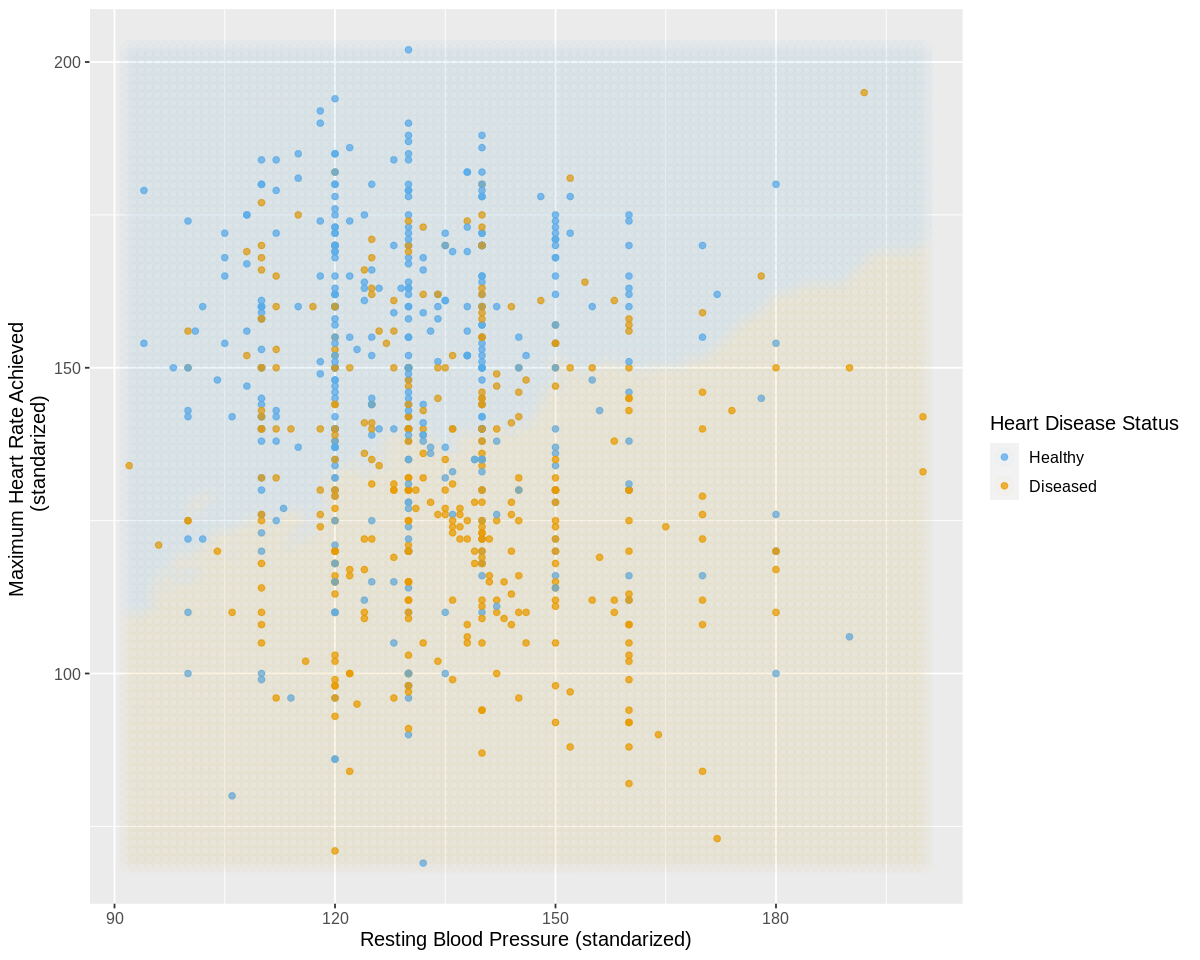

In [45]:
set.seed (123)
heart_data_3 <- read_csv("data/heart.csv") |>
    filter(Cholesterol!=0) |>
    mutate(HeartDisease = as.factor(HeartDisease))|>
    select(RestingBP, MaxHR, HeartDisease) 


knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 66) |>
        set_engine("kknn") |>
        set_mode("classification")

uc_recipe <- recipe(HeartDisease ~ RestingBP + MaxHR, data = heart_data_3) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit2 <- workflow() |>
  add_recipe(uc_recipe) |>
  add_model(knn_spec2) |>
  fit(data = heart_data_3)




rbp_grid <- seq(min(heart_data_3$RestingBP), 
                max(heart_data_3$RestingBP), 
                length.out = 100)

mhr_grid <- seq(min(heart_data_3$MaxHR), 
                max(heart_data_3$MaxHR), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(RestingBP = rbp_grid, 
                                MaxHR = mhr_grid))


knnPredGrid2 <- predict(knn_fit2, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid2, asgrid) |> 
  rename(HeartDisease = .pred_class)


wkflw_plot2 <-
  ggplot() +
  geom_point(data = heart_data_3, 
             mapping = aes(x = RestingBP, 
                           y = MaxHR, 
                           color = HeartDisease), 
             alpha = 0.75) +

  geom_point(data = prediction_table, 
             mapping = aes(x = RestingBP, 
                           y = MaxHR, 
                           color = HeartDisease), 
             alpha = 0.02, size = 5) +

    labs(color = "Heart Disease Status", 
       x = "Resting Blood Pressure (standarized)", 
       y = "Maximum Heart Rate Achieved \n (standarized)") +
    ggtitle("C Heart Disease Cases Based on Maximum Heart Rate \nand Resting Blood Pressure") +
    scale_color_manual(labels = c("Healthy","Diseased"), 
                     values = c("steelblue2","orange2")) +
  theme(text = element_text(size = 12))

wkflw_plot2

## Discussion:

By developing this model, we expect to be able to predict heart disease, with a reasonable accuracy for application in healthcare, based on the biological determinants and symptoms observed in individuals. In particular, this model predicts the heart disease by taking some of the most important risk factors into consideration. It anticipates the presence, or the absence of the heart disease based on the combination of these numerical variables in a systemic approach, instead of relying on the personal judgement of a healthcare provider.
 Therefore, our model can lay the groundwork for designing a potential diagnostic tool assisting healthcare professionals to address life threatening heart diseases earlier and more accurately. 
Also, in our analysis, some relationships may be observed between heart disease and the predictors.
These observations can lead the researchers to answer further questions like what the physiological
mechanisms behind these relationships are. This model can be expanded by designing a model capable of predicting heart disease in individuals considering different types of chest pains and across different genders, which are the limitations of the current model.
One the possible reasons for the relatively low accuracy of this model can be the potential confounding effects between some of the predictors that we were not able to address due the limitations of the model or the dataset. For example, in Figure 1, we can see that there is no correlation between the cholesterol level and the heart disease, which is not consistent with what is known medically. Thus, maybe the negative effect of high cholesterol in heart diseases can be observed when it is considered along with the amount of exercise (not numerical) or stress levels (not available in the dataset).

In [ ]:
future question 
2 paraghraphs 

## Refrences
1.Tsao CW, Aday AW, Almarzooq ZI, Beaton AZ, Bittencourt MS, Boehme AK, et al. Heart Disease and Stroke Statistics—2022 Update: A Report From the American Heart Association. Circulation. 2022;145(8):e153–e639.

2.Centers for Disease Control and Prevention, National Center for Health Statistics. About Multiple Cause of Death, 1999–2020. CDC WONDER Online Database website. Atlanta, GA: Centers for Disease Control and Prevention; 2022. Accessed February 21, 2022.

3.fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.
